In [1]:
using FFTW, DSP, Colors, FileIO, ImageCore, Plots, StatsBase, ImageShow, LinearAlgebra

jpeg_coefficient_numbers = [1  2  6  7  15 16 28 29;
 3  5  8  14 17 27 30 43;
 4  9  13 18 26 31 42 44;
 10 12 19 25 32 41 45 54;
 11 20 24 33 40 46 53 55;
 21 23 34 39 47 52 56 61;
 23 35 38 48 51 57 60 62;
 36 37 49 50 58 59 63 64;]

8×8 Matrix{Int64}:
  1   2   6   7  15  16  28  29
  3   5   8  14  17  27  30  43
  4   9  13  18  26  31  42  44
 10  12  19  25  32  41  45  54
 11  20  24  33  40  46  53  55
 21  23  34  39  47  52  56  61
 23  35  38  48  51  57  60  62
 36  37  49  50  58  59  63  64

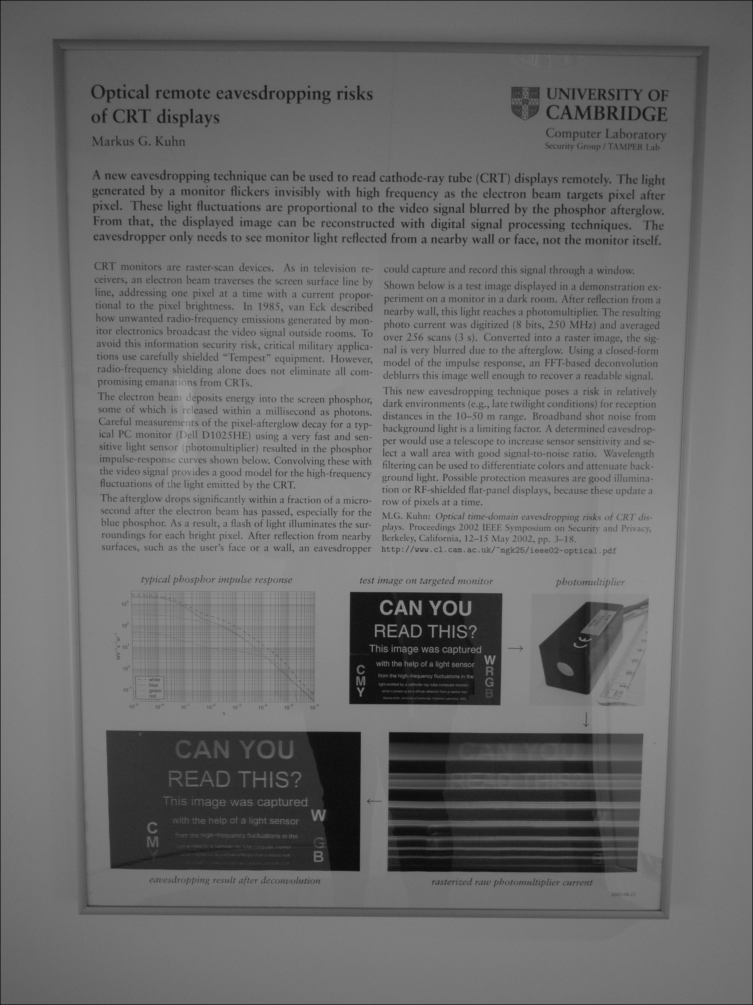

In [2]:
image_1_bw_test = (FileIO.load("test_images/test1.png"))
image_2_bw_test = (FileIO.load("test_images/test2.png"))
image_3_bw_test = (FileIO.load("test_images/test3.png"))

image_1_c_test = channelview(YCbCr.(FileIO.load("test_images/test1c.png")))
image_2_c_test = channelview(YCbCr.(FileIO.load("test_images/test2c.png")))
image_3_c_test = channelview(YCbCr.(FileIO.load("test_images/test3c.png")))

# image_1_bw_test = (FileIO.load("example_images/poster_bw_jpeg100.png"))
image_2_bw_test = (FileIO.load("example_images/poster_bw_jpeg90.png"))
# image_3_bw_test = (FileIO.load("example_images/poster_bw_jpeg25.png"))

# image_1_c_test = channelview(YCbCr.(FileIO.load("example_images/poster_c_jpeg100.png")))
# image_2_c_test = channelview(YCbCr.(FileIO.load("example_images/poster_c_jpeg75.png")))
# image_3_c_test = channelview(YCbCr.(FileIO.load("example_images/poster_c_jpeg50.png")))

## Method 1: Detecting Blocking

This is looking to make use of the blocking detection algorithm presented inside of `Identification of Bitmap Compression History: JPEG Detection and Quantizer Estimation`, I believe we know that the blocking for our JPEG compression starts aligned to the images are they are helpfully aligned to have both width and height be divisible by 8.

In [165]:
function calculate_hist_difference(image_luminace, number_of_bins)
    Z_prime = zeros(axes(image_luminace)[1][end] ÷ 8 - 1, axes(image_luminace)[2][end] ÷ 8 - 1)
    Z_double_prime = zeros(axes(image_luminace)[1][end] ÷ 8 - 1, axes(image_luminace)[2][end]  ÷ 8 - 1)

    for i in 1:axes(Z_prime)[1][end]
        for j in 1:axes(Z_prime)[2][end]
            Z_prime[i,j] = abs(image_luminace[8 * i - 4, 8 * j - 4] + image_luminace[8 * i - 3, 8 * j - 3] - image_luminace[8 * i - 4, 8 * j - 3] - image_luminace[8 * i - 3, 8 * j - 4])
            Z_double_prime[i,j] = abs(image_luminace[8 * i, 8 * j] + image_luminace[8 * i + 1, 8 * j + 1] - image_luminace[8 * i, 8 * j + 1] - image_luminace[8 * i + 1, 8 * j])
        end
    end

    unrolled_Z_prime = vec(Z_prime)
    unrolled_Z_double_prime = vec(Z_double_prime)

    max_value_present = max(maximum(unrolled_Z_prime), maximum(unrolled_Z_double_prime))
    bins = range(0, max_value_present + 0.01, number_of_bins + 1)

    Z_prime_hist = fit(Histogram, unrolled_Z_prime, bins)
    Z_double_prime_hist = fit(Histogram, unrolled_Z_double_prime, bins)

    Z_prime_hist = normalize(Z_prime_hist, mode=:probability)
    Z_double_prime_hist = normalize(Z_double_prime_hist, mode=:probability)

    p1 = plot(Z_prime_hist, α=0.5, lab="Z'")
    plot!(p1, Z_double_prime_hist, α=0.5, lab="Z''")

    return (sum(abs.((Z_double_prime_hist.weights) .- (Z_prime_hist.weights))), p1)
end

calculate_hist_difference (generic function with 1 method)

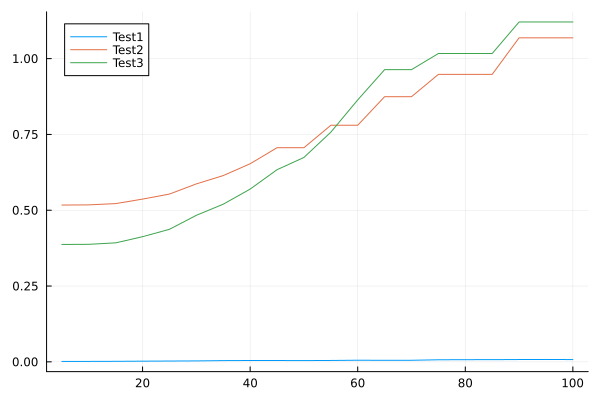

In [166]:
number_of_bins_range = 5:5:100

image_1_bw_Ks = zeros(length(number_of_bins_range))
image_2_bw_Ks = zeros(length(number_of_bins_range))
image_3_bw_Ks = zeros(length(number_of_bins_range))

for num_of_bins in number_of_bins_range
    image_1_bw_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_1_bw_test, num_of_bins)
    image_2_bw_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_2_bw_test, num_of_bins)
    image_3_bw_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_3_bw_test, num_of_bins)
end

plot(number_of_bins_range, [image_1_bw_Ks image_2_bw_Ks image_3_bw_Ks]; labels=["Test1" "Test2" "Test3"])

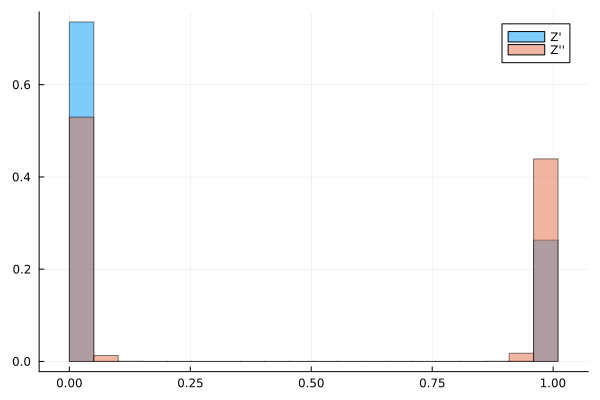

In [167]:
_, p = calculate_hist_difference(image_3_bw_test, 20)
plot(p)

This plot is clearly showing us that for the black and white images then the block detection algorithm is clearly giving far higher values for the images test2 and test3, showing that they have undergone at least one round of JPEG compression whereas test1c has not been through any compression.

The same technique is also used on the luminance channel of the colour images to attempt to identify if they have also been through a JPEG compression, we can also use another technique of simply trying to identify if they have been chroma-subsampled.

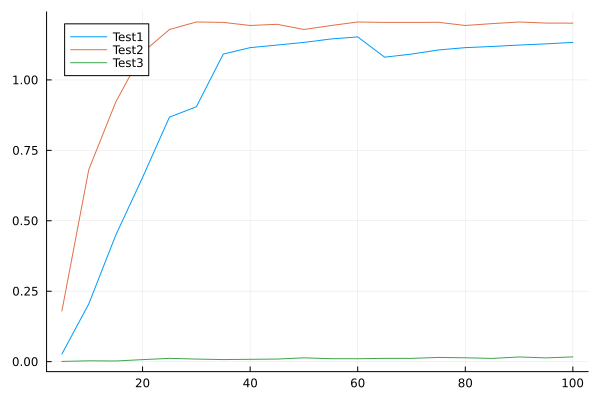

In [168]:
image_1_c_Ks = zeros(length(number_of_bins_range))
image_2_c_Ks = zeros(length(number_of_bins_range))
image_3_c_Ks = zeros(length(number_of_bins_range))

for num_of_bins in number_of_bins_range
    image_1_c_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_1_c_test[1,:,:], num_of_bins)
    image_2_c_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_2_c_test[1,:,:], num_of_bins)
    image_3_c_Ks[num_of_bins ÷ 5], _ = calculate_hist_difference(image_3_c_test[1,:,:], num_of_bins)
end

plot(number_of_bins_range, [image_1_c_Ks image_2_c_Ks image_3_c_Ks]; labels=["Test1" "Test2" "Test3"])

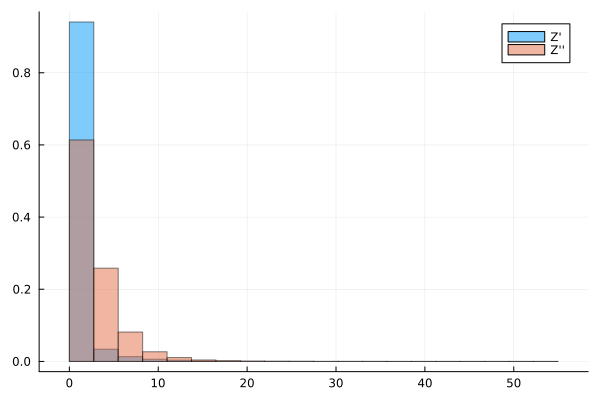

In [169]:
_, p = calculate_hist_difference(image_1_c_test[1,:,:], 20)
plot(p)

# Method 2: Detecting Chroma Subsampling

The basic idea behind this is that using chroma subsampling in `cjpeg` means that every group of 4 pixels in the colour images should have the same values for the chroma in every 2 by 2 block of pixels

In [170]:
function calculate_max_chroma_difference(image_chroma_channel)
    avg_diff = 0
    num_of_diffs = 0
    for i in 1:2:axes(image_chroma_channel)[1][end]
        for j in 1:2:axes(image_chroma_channel)[2][end]
            small_block = image_chroma_channel[i:i+1, j:j+1]
            diff = maximum(small_block) - minimum(small_block)
            avg_diff += diff
            num_of_diffs += 1
        end
    end
    return avg_diff / num_of_diffs
end

calculate_max_chroma_difference (generic function with 1 method)

In [171]:
img1_diff = (calculate_max_chroma_difference(image_1_c_test[2,:,:]) + calculate_max_chroma_difference(image_1_c_test[3,:,:])) / 2
img2_diff = (calculate_max_chroma_difference(image_2_c_test[2,:,:]) + calculate_max_chroma_difference(image_2_c_test[3,:,:])) / 2
img3_diff = (calculate_max_chroma_difference(image_3_c_test[2,:,:]) + calculate_max_chroma_difference(image_3_c_test[3,:,:])) / 2

2.390078f0

In [172]:
println("Image 1 ", img1_diff)
println("Image 2 ", img2_diff)
println("Image 3 ", img3_diff)

Image 1 0.15880647
Image 2 0.56288165
Image 3 2.390078


From the combination of attempting to identify chromasubsampling and also looking for blocking artefacts in the luminance channel we can see that both test1c and test2c have been through jpeg compression whereas test3c has not.  For these analyses they can technically have been through jpeg compression with a quality factor of 100 because that does not really perform any actual compression.

# Method 3: Histograms of coefficients

The purpose of this is to attempt to work out if they have been through multiple levels of jpeg compression.  This should be identifiable in the resulting histograms as clear spikes with valleys in between.  This method is clearly not fool proof because one of the compressions is much stronger than the other especially if the second then it will effectively crush the compression performed in the first.

In [109]:
function DCT_coefficients_grayscale(image_folder, image_name)
    base_image = Gray.(FileIO.load(image_folder * image_name * ".png"))
    dct_coefficients = zeros(length(base_image) ÷ 64, 8, 8)
    block_index = 1
    for i in 1:8:axes(base_image)[1][end]
        for j in 1:8:axes(base_image)[2][end]
            block = Float64.(base_image[i:i+7, j:j+7])
            block_coefficients = FFTW.dct(block .- mean(block))
            dct_coefficients[block_index, :, :] = block_coefficients
            block_index += 1
        end
    end
    return dct_coefficients
end

DCT_coefficients_grayscale (generic function with 1 method)

In [143]:
function make_histogram(dct_coefficients, row, col) 
    coefficients = dct_coefficients[:, row, col]
    estimated_bin_width = 2 * iqr(coefficients) / (length(coefficients) ^ (1 / 3)) #Ises Freedman-Diaconis'_choice
    bins = minimum(coefficients)-0.05:estimated_bin_width:maximum(coefficients)+0.05
    dct_hist = fit(Histogram, coefficients, bins)
    return bar(replace(log10.(dct_hist.weights), -Inf => 0))
end

make_histogram (generic function with 1 method)

In [144]:
bw_test1_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test1")
p_test1_bw = make_histogram(bw_test1_dct_coefficients, 2, 1)
savefig(p_test1_bw, "test1_bw_2_1_hist.svg")

bw_test2_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test2")
p_test2_bw = make_histogram(bw_test2_dct_coefficients, 2, 1)
savefig(p_test2_bw, "test2_bw_2_1_hist.svg")

bw_test3_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test3")
p_test3_bw = make_histogram(bw_test3_dct_coefficients, 2, 1)
savefig(p_test3_bw, "test3_bw_2_1_hist.svg")

"d:\\Year_4_Part_3\\Digital Signal Processing\\Mini Project\\test3_bw_2_1_hist.svg"

From these output plots it is relatively clear that test2 has been through jpeg compression only once because the rough shape of its histogram smoothly drops down (just looking at the peaks, this is because each of these peaks is centered around a multiple of the quantisation value which was used for this value).

This is in comparison to test3 where the drop downs are not quite so consistent and instead have much more times where they head back up significantly in some sort of patterns.  This is also telling us that the second application of jpeg compression was at a lower quality than the first application.  This is because there are not clear drops down to zero.

In [145]:
bw_test1_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test1c")
p_test1_bw = make_histogram(bw_test1_dct_coefficients, 2, 1)
savefig(p_test1_bw, "test1_c_2_1_hist.svg")

bw_test2_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test2c")
p_test2_bw = make_histogram(bw_test2_dct_coefficients, 2, 1)
savefig(p_test2_bw, "test2_c_2_1_hist.svg")

bw_test3_dct_coefficients = DCT_coefficients_grayscale("test_images/", "test3c")
p_test3_bw = make_histogram(bw_test3_dct_coefficients, 2, 1)
savefig(p_test3_bw, "test3_c_2_1_hist.svg")

"d:\\Year_4_Part_3\\Digital Signal Processing\\Mini Project\\test3_c_2_1_hist.svg"

From these histograms it is also relatively clear that test2c has been through JPEG compression twice whereas test1c has only been through it once

In [147]:
poster_single_coef = DCT_coefficients_grayscale("example_images/", "poster_bw_jpeg75")
poster_single_hist = make_histogram(poster_single_coef, 2, 1)
savefig(poster_single_hist, "poster_75_hist.svg")

poster_double_coef = DCT_coefficients_grayscale("example_images/", "poster_bw_jpeg70_85")
poster_double_hist = make_histogram(poster_double_coef, 2, 1)
savefig(poster_double_hist, "poster_70_85_hist.svg")

poster_double_coef = DCT_coefficients_grayscale("example_images/", "poster_bw_jpeg85_70")
poster_double_hist = make_histogram(poster_double_coef, 2, 1)
savefig(poster_double_hist, "poster_85_70_hist.svg")

"d:\\Year_4_Part_3\\Digital Signal Processing\\Mini Project\\poster_85_70_hist.svg"

# Method 4: Plotting Absolute Differences when it has been recompressed at different quality levels

In [315]:
function absolute_difference_grayscale(image_folder, image_name)
    base_image = Float64.(FileIO.load(image_folder * image_name * ".png"))
    differences = zeros(100)
    for i in 1:100
        recompressed_image = Float64.(FileIO.load(image_name * "_recompressed/test_" * string(i) * ".png"))
        differences[i] = mean(abs.(base_image .- recompressed_image))
    end
    return differences
end

absolute_difference_grayscale (generic function with 1 method)

In [352]:
# test2c_differences = absolute_difference_grayscale("test_images/","test2c")
# test3c_differences = absolute_difference_grayscale("test_images/","test3c")
# example_70_85_differences = absolute_difference_grayscale("example_images/","poster_bw_jpeg70_85")
# example_85_70_differences = absolute_difference_grayscale("example_images/","poster_bw_jpeg85_70")
example_75_differences = absolute_difference_grayscale("example_images/","poster_bw_jpeg75")

100-element Vector{Float64}:
 0.06412133654057113
 0.048981923850800385
 0.03680358418744712
 0.030819304979186286
 0.02599356595572237
 0.022232840319468882
 0.019420415244009358
 0.017667791950159308
 0.01638134213510995
 0.015532587006999119
 ⋮
 0.0007234168899080358
 0.0005589994008114393
 0.0004938530322805565
 0.00032047608741089047
 0.0002825917985338579
 0.00025101052039235635
 0.00023463554781707547
 0.0002234776995480739
 0.0001866247593065369

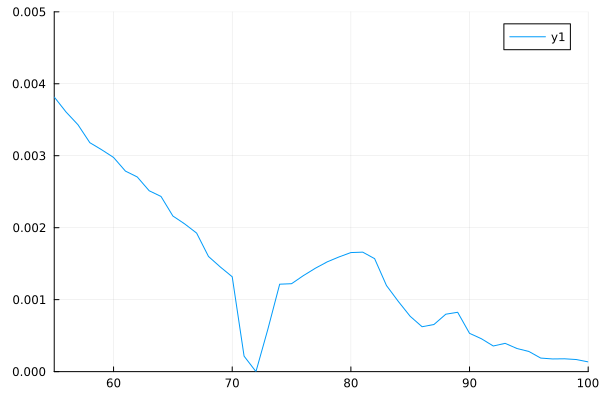

In [330]:
plot(test2_differences; xlim=(55,100), ylim=(0,0.005))

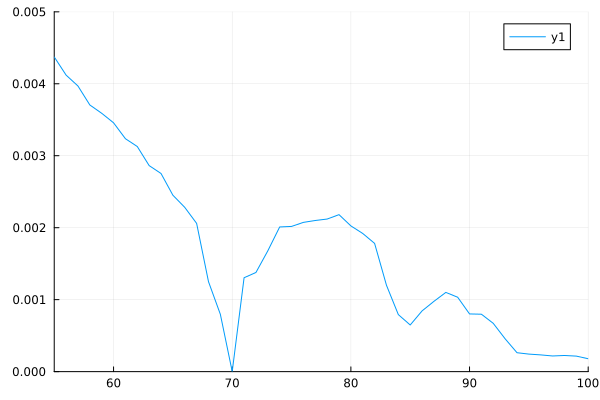

In [336]:
plot(test3_differences, xlim=(55,100), ylim=(0,0.005))

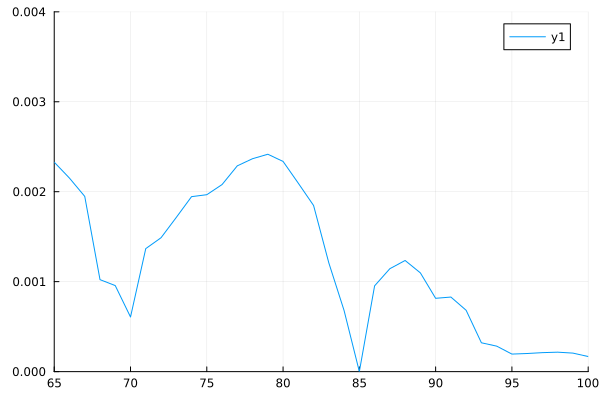

In [350]:
plot(example_70_85_differences; xlim=(65,100), ylim=(0,0.004))

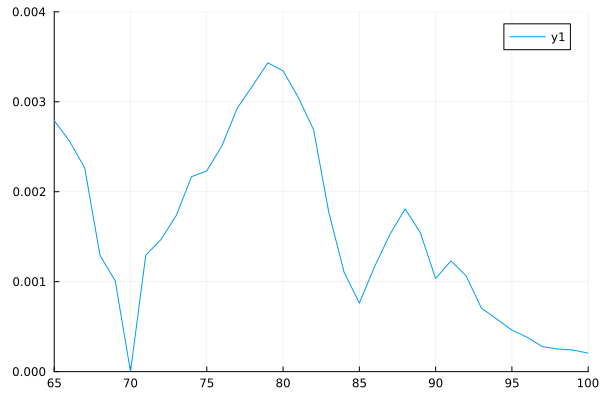

In [351]:
plot(example_85_70_differences; xlim=(65,100), ylim=(0,0.004))

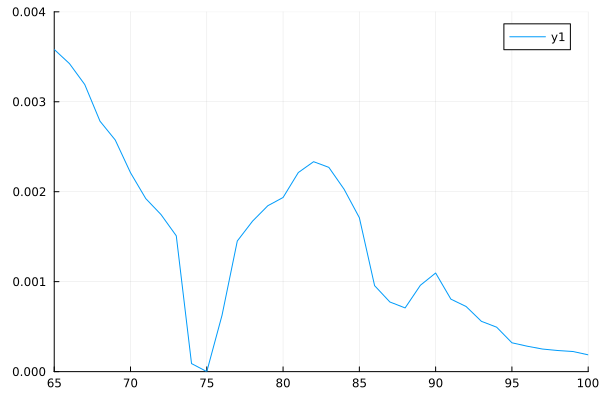

In [353]:
plot(example_75_differences; xlim=(65,100), ylim=(0,0.004))

From this plot we can estimate that for test2c it was compressed with a quality factor of 72 because it leads to an incredibly small difference when recompressed with that quality factor.  This is due to jpeg having a property of idempotence.

We can also see clearly from the plot that test3 is compressed with a quality of factor 70 second and Looks to be slightly indicating that it was first compressed with a factor of 85.